In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Dataset
- Binary Classification
- X: Planar point (x1, x2) -> y: 0 or 1


In [2]:
def create_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y.reshape(-1)

X, Y = create_dataset()
print(f'{X.shape = }, {Y.shape = }')

X.shape = (400, 2), Y.shape = (400,)


#### Visualize the data

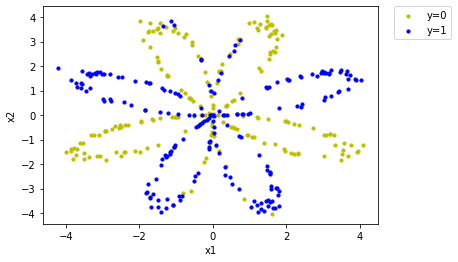

In [3]:
cmap = {0:'y', 1:'b'}
for label in [0, 1]:
    plt.scatter(
        x=X[(Y == label), 0], y=X[(Y == label), 1],
        c=f'{cmap[label]}', marker='o', s=10, label=f'y={label}')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('x2')
plt.xlabel('x1')
plt.show()

# 3. Model
#### Notation

$$x_j^{(i)[l]}$$
- $[l]$: layer l-th (L layers)
+ $(i)$: data point i-th (m data points)
+ $j$: feature j-th (n features)

<img src="./assets/classification_kiank.png" width="780"/>


## 3.1 Foward
### 3.1.1 Data point view

- Input $x^{(i)}$: data point i-th, size `(input_dim,)`

#### Layer 1: Hidden layer

$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$

#### Layer 2: Output Layer
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \text{sigmoid}(z^{ [2] (i)})\tag{4}$$

### 3.1.2 Matrix-batch view
#### Tensor note
- Data
    + `m`: batch size
    - $X$: Input data, shape `(input_dim, m)`
    - $Y$: shape `(output_dim, m)`
- Layer 1
    - $W^{[1]}$: shape `(hidden_dim, input_dim)`
    - $b^{[1]}$: shape `(1, hidden_dim)`
    - $A^{[1]},\ Z^{[1]}$: shape `(hidden_dim, m)`
- Layer 2
    - $W^{[2]}$: shape `(output_dim, hidden_dim)`
    - $b^{[2]}$: shape `(1, output_dim)`
    - $\hat{Y},\ A^{[2]},\ Z^{[2]}$: shape `(output_dim, m)`

#### Layer 1: Hidden layer
$$Z^{[1]} =  W^{[1]} \cdot X + b^{[1]}\tag{1}$$ 
$$A^{[1]} = \tanh(Z^{[1]})\tag{2}$$

#### Layer 2: Output Layer
$$Z^{[2]} = W^{[2]} \cdot A^{[1]} + b^{[2]}\tag{3}$$
$$\hat{Y} = A^{[2]} = \text{sigmoid}(Z^{[2]})\tag{4}$$

In [4]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): input size (m,)

    Returns:
        g (ndarray): sigmoid(z), size (m,)
    """
    return 1.0 / (1.0 + np.exp(-z))

In [5]:
def forward_propagation(X, parameters):
    """
    Compute forward propagation of L1 and L2
    
    Args:
        X : Input data, shape (input_dim, m)
        parameters : python dictionary containing parameters (W1, b1, W2, b2)
    
    Returns:
        A2 : The sigmoid output of the second activation, shape (output_dim, m)
        cache : a dictionary containing 'Z1', 'A1', 'Z2' and 'A2'
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']

    # Forward Propagation
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    # Return
    cache = {'Z1': Z1,
             'A1': A1,
             'Z2': Z2,
             'A2': A2}
    return A2, cache

## 3.2 Cost function
- Loss Function for each data point (i)
$$\begin{split}
    L(\hat{y}^{(i)}, y^{(i)}) &= -y^{(i)} \log(\hat{y}^{(i)}) - (1 - y^{(i)}) \log(1 - \hat{y}^{(i)})
\end{split}$$

- Cost function

$$J(w,b) = \frac{1}{m} \sum\limits_{i=0}^{m-1} \left[ L(\hat{y}^{(i)}, y^{(i)}) \right]$$

In [6]:
def compute_cost(Y_hat, Y):
    """
    Computes the cross-entropy cost

    Args:
        Y_hat : The sigmoid output of the second activation, of shape (1, m)
        Y : "true" labels vector of shape (1, m)

    Returns:
        cost : cross-entropy cost
    """
    # number of example
    m = Y.shape[1]

    # Compute the cross-entropy cost
    L = -np.multiply(Y ,np.log(Y_hat)) - np.multiply(1-Y, np.log(1-Y_hat))
    J = 1./m * np.sum(L, axis=1)
    
    # makes sure cost is the dimension we expect. 
    #     E.g., turns [[17]] into 17
    J = float(np.squeeze(J))
    assert(isinstance(J, float))

    return J

## 3.3 Backpropagation
- Derivative of $g(z) = \tanh(z)$

$$\begin{split}
    \frac{\partial g(z)}{\partial z} &= 1 - g^2(z) 
\end{split}$$

#### Layer 2 - $A^{[2]}$ sigmoid

$\begin{align}
\frac{\partial J(w,b)}{\partial W^{[2]}}  &= \frac{\partial J}{\partial A^{[2]}} \frac{\partial A^{[2]}}{\partial Z^{[2]}} \frac{\partial Z^{[2]}}{\partial W^{[2]}} \\
    &= \frac{1}{m} \sum\limits_{i=0}^m \left[ \frac{A^{[2]} - Y}{A^{[2]} (1 - A^{[2]})} \right]  \left[ A^{[2]}(1 - A^{[2]}) \right] \left[ A^{[1]\ T} \right] \textbf{ (Note)} \\
    &= \frac{1}{m} \sum\limits_{i=0}^m \left[ (A^{[2]} - Y) \cdot A^{[1]\ T} \right]
\end{align}$

$\begin{align}
\frac{\partial J(w,b)}{\partial b^{[2]}}  &= \frac{\partial J}{\partial A^{[2]}} \frac{\partial A^{[2]}}{\partial Z^{[2]}} \frac{\partial Z^{[2]}}{\partial b^{[2]}} \\
    &= \frac{1}{m} \sum\limits_{i=0}^m \left[ \frac{A^{[2]} - Y}{A^{[2]} (1 - A^{[2]})} \right]  \left[ A^{[2]}(1 - A^{[2]}) \right] \textbf{ (Note)} \\
    &= \frac{1}{m} \sum\limits_{i=0}^m \left[ A^{[2]} - Y \right]
\end{align}$

#### Layer 1 - $A^{[1]}$ tanh

$\begin{align}
\frac{\partial J(w,b)}{\partial W^{[1]}}  &= \frac{\partial J}{\partial A^{[2]}} \frac{\partial A^{[2]}}{\partial Z^{[2]}} \frac{\partial Z^{[2]}}{\partial A^{[1]}} \frac{\partial A^{[1]}}{\partial Z^{[1]}} \frac{\partial Z^{[1]}}{\partial W^{[1]}} \\
    &= \frac{\partial J}{\partial Z^{[2]}}  \frac{\partial Z^{[2]}}{\partial A^{[1]}} \frac{\partial A^{[1]}}{\partial Z^{[1]}} \frac{\partial Z^{[1]}}{\partial W^{[1]}} \\
    &= \frac{1}{m} \sum\limits_{i=0}^m \left[ (A^{[2]} - Y) \right] \left[ W^{[2]\ T}\right] \left[ 1 - \left(A^{[1]} \right)^2 \right] \left[ X^T \right] \\
    &= \frac{1}{m} \sum\limits_{i=0}^m \left[ W^{[2]\ T} \cdot (A^{[2]} - Y) \left( 1 - \left(A^{[1]} \right)^2 \right) \cdot X^T \right]
\end{align}$

$\begin{align}
\frac{\partial J(w,b)}{\partial b^{[1]}}  &= \frac{\partial J}{\partial A^{[2]}} \frac{\partial A^{[2]}}{\partial Z^{[2]}} \frac{\partial Z^{[2]}}{\partial A^{[1]}} \frac{\partial A^{[1]}}{\partial Z^{[1]}} \frac{\partial Z^{[1]}}{\partial b^{[1]}} \\
&= \frac{\partial J}{\partial Z^{[2]}}  \frac{\partial Z^{[2]}}{\partial A^{[1]}} \frac{\partial A^{[1]}}{\partial Z^{[1]}} \frac{\partial Z^{[1]}}{\partial b^{[1]}} \\
&= \frac{\partial J}{\partial Z^{[2]}}  \frac{\partial Z^{[2]}}{\partial A^{[1]}} \frac{\partial A^{[1]}}{\partial Z^{[1]}} \frac{\partial Z^{[1]}}{\partial W^{[1]}} \\
    &= \frac{1}{m} \sum\limits_{i=0}^m \left[ (A^{[2]} - Y) \right] \left[ W^{[2]\ T}\right] \left[ 1 - \left(A^{[1]} \right)^2 \right] \left[ 1 \right] \\
    &= \frac{1}{m} \sum\limits_{i=0}^m \left[  W^{[2]\ T} \cdot (A^{[2]} - Y) \left( 1 - \left(A^{[1]} \right)^2 \right) \right]
\end{align}$

In [7]:
def backward_propagation(parameters, cache, X, Y):
    """
    backward propagation
    
    Arguments:
        parameters : python dictionary containing our parameters 
        cache : a dictionary containing "Z1", "A1", "Z2" and "A2".
        X : input data of shape (input_dim, m)
        Y : labels vector of shape (output_dim, m)

    Returns:
        grads : python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]

    # Retrieve W1 and W2 from the dictionary "parameters".
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']
        
    # Retrieve A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']

    # Backward propagation: calculate dJ_dW1, dJ_db1, dJ_dW2, dJ_db2
    dJ_dW2 = 1./m * np.dot(A2 - Y, A1.T)
    dJ_db2 = 1./m * np.sum(A2 - Y, axis=1, keepdims=True) # (A2-Y).shape = (out_dim, m)
    
    dJ_dW1 = 1./m * np.dot(W2.T @ (A2 - Y) * (1 - np.power(A1, 2)), X.T)
    dJ_db1 = 1./m * np.sum(W2.T @ (A2 - Y) * (1 - np.power(A1, 2)), axis=1, keepdims=True)
    
    # Return grad
    grads = {'dW1': dJ_dW1,
             'db1': dJ_db1,
             'dW2': dJ_dW2,
             'db2': dJ_db2}
    return grads

- We can compute backpropagation Layer by Layer:

```
dA2 -> dZ2 -> dA1 -> dZ1
        |             |
    (dW2,db2)     (dW1,db1)
```

- **Denote**: $dx = \frac{\partial J}{\partial x} $

$\begin{split}
    dA^{[2]} = \frac{\partial J}{\partial A^{[2]}} = \frac{A^{[2]} - Y}{A^{[2]} (1 - A^{[2]})}
\end{split}$

$\begin{split}
    dZ^{[2]} = \frac{\partial J}{\partial Z^{[2]}} = \frac{\partial J}{\partial A^{[2]}}  \frac{\partial A^{[2]}}{\partial Z^{[2]}} = dA^{[2]} \left[ A^{[2]}(1 - A^{[2]}) \right]
\end{split}$

$$\begin{split}
    dW^{[2]} &= \frac{\partial J}{\partial W^{[2]}} = \frac{\partial J}{\partial Z^{[2]}}  \frac{\partial Z^{[2]}}{\partial W^{[2]}} = \frac{1}{m} \sum\limits_{i=0}^m  \left[ dZ^{[2]} \left[ A^{[1]\ T} \right] \right] = \frac{1}{m} \sum\limits_{i=0}^m \left[ dZ^{[2]} \cdot A^{[1]\ T} \right] \\
    db^{[2]} &= \frac{\partial J}{\partial b^{[2]}} = \frac{\partial J}{\partial Z^{[2]}}  \frac{\partial Z^{[2]}}{\partial b^{[2]}} = \frac{1}{m} \sum\limits_{i=0}^m dZ^{[2]}
\end{split}$$

$\begin{split}
    dA^{[1]} = \frac{\partial J}{\partial A^{[1]}} = \frac{\partial J}{\partial Z^{[2]}}  \frac{\partial Z^{[2]}}{\partial A^{[1]}} = dZ^{[2]} \left[ W^{[2]\ T} \right] = W^{[2]\ T} \cdot dZ^{[2]} 
\end{split}$

$\begin{split}
    dZ^{[1]} = \frac{\partial J}{\partial Z^{[1]}} = \frac{\partial J}{\partial A^{[1]}}  \frac{\partial A^{[1]}}{\partial Z^{[1]}} = dA^{[1]} \left[ 1 - \left(A^{[1]} \right)^2  \right]
\end{split}$

$$\begin{split}
    dW^{[1]} &= \frac{\partial J}{\partial W^{[1]}} = \frac{\partial J}{\partial Z^{[1]}}  \frac{\partial Z^{[1]}}{\partial W^{[1]}} = \frac{1}{m} \sum\limits_{i=0}^m \left[ dZ^{[1]} \left[ X^T \right] \right] = \frac{1}{m} \sum\limits_{i=0}^m \left[ dZ^{[1]} \cdot  X^T \right] \\
    db^{[1]} &= \frac{\partial J}{\partial b^{[1]}} = \frac{\partial J}{\partial Z^{[1]}}  \frac{\partial Z^{[1]}}{\partial b^{[1]}} = \frac{1}{m} \sum\limits_{i=0}^m dZ^{[1]}
\end{split}$$

In [8]:
def backward_propagation(parameters, cache, X, Y):
    """
    backward propagation
    
    Arguments:
        parameters : python dictionary containing our parameters 
        cache : a dictionary containing "Z1", "A1", "Z2" and "A2".
        X : input data of shape (input_dim, m)
        Y : labels vector of shape (output_dim, m)

    Returns:
        grads : python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]

    # Retrieve W1 and W2 from the dictionary "parameters".
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']
        
    # Retrieve A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']

    # Backward propagation
    dA2 = np.divide(A2 - Y, A2*(1-A2))
    dZ2 = np.multiply(dA2, A2*(1-A2))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, 1 - np.power(A1, 2))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)

    # Return grad
    grads = {'dW1': dW1,
             'db1': db1,
             'dW2': dW2,
             'db2': db2}
    return grads

# 4. Train

In [9]:
def fit(
        X, Y, hidden_dim=4,
        alpha=1e-2, num_iters=1000):
    """
    Train Fully Connected NN - 2 Layer - Binary Classification
    
    Arguments:
        X : input data of shape (m, input_dim)
        Y : labels 0,1 vector of shape (m,)
        hidden_dim (scalar): number of hidden_dim of Layer 1 

    Returns:
        params : python dictionary containing parameters W1, b1, W2, b2
        J_history : History of Cost function for plotting
    """
    ## Reformat X, Y
    # (m, input_dim) -> (input_dim, m)
    X = X.T
    # (m,) -> (output_dim, m)
    Y = Y.reshape(1, -1)
    
    # size
    input_dim = X.shape[0]
    hidden_dim = 4
    output_dim = Y.shape[0]

    # Initialize parameters
    params = {
        'W1': np.random.randn(hidden_dim, input_dim) * 0.1,
        'b1': np.zeros((hidden_dim, 1)),
        'W2': np.random.randn(output_dim, hidden_dim) * 0.1,
        'b2': np.zeros((output_dim, 1))}
    
    # Iters
    J_history = []
    for i in range(num_iters):

        # Forward
        Y_hat, cache = forward_propagation(X, params)
        
        # Compute Cost
        if i<100000:
            cost = compute_cost(Y_hat, Y)
            J_history.append(cost)
        
        # Back Propagation
        grads = backward_propagation(params, cache, X, Y)
        
        # Update params
        params['W1'] -= alpha * grads['dW1']
        params['b1'] -= alpha * grads['db1']
        params['W2'] -= alpha * grads['dW2']
        params['b2'] -= alpha * grads['db2']
        
        if i % 10000 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))

    return params, J_history

In [10]:
parameters, J_hist = fit(
    X=X , Y=Y, hidden_dim=50,
    alpha=1e-2, num_iters=100000)

Cost after iteration 0: 0.690382
Cost after iteration 10000: 0.387034
Cost after iteration 20000: 0.331288
Cost after iteration 30000: 0.315590
Cost after iteration 40000: 0.307030
Cost after iteration 50000: 0.301229
Cost after iteration 60000: 0.296830
Cost after iteration 70000: 0.293210
Cost after iteration 80000: 0.290033
Cost after iteration 90000: 0.287210


#### Training param plot

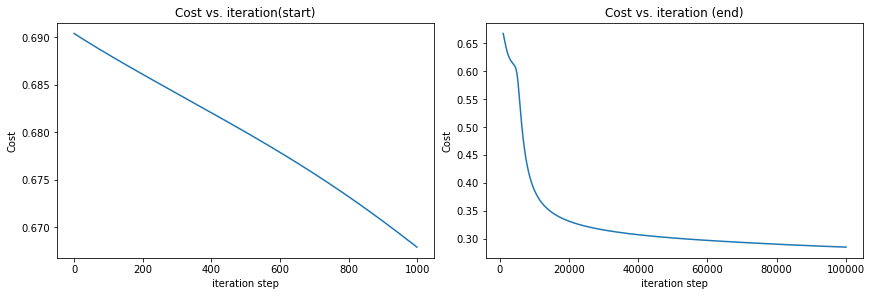

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))

ax1.plot(J_hist[:1000])
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step')
plt.show()

# 6. Inference

#### Decision Boundary

In [12]:
def plot_data(X, y):
    cmap = {0:'y', 1:'b'}
    for label in [0, 1]:
        plt.scatter(
            x=X[(y == label), 0], y=X[(y == label), 1],
            c=f'{cmap[label]}', marker='o', s=10, label=f'y={label}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('x2')
    plt.xlabel('x1')

def plot_decision_boundary(model, X, y):
    """
    plot_decision_boundary - Binary Classification - (X,Y) Coordinates
    
    Arguments:
        model (func) : predictions model; y_hat = model(X)
        X : input data of shape (m, 2)
        y : labels 0,1 vector of shape (m,)
    Returns:
        Contour plotting
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    
    # Plot data
    plot_data(X, y)
    plt.show()

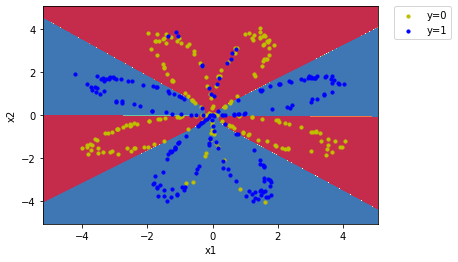

In [13]:
def predict(x, parameters):
    y_hat, _ = forward_propagation(x.T, parameters)
    predictions = (y_hat >= 0.5)
    return predictions

plot_decision_boundary(lambda x: predict(x, parameters), X, Y)

#### Accuracy

In [14]:
Y_hat, _ = forward_propagation(X.T, parameters)
Y_hat = Y_hat.reshape(-1) 

accuracy = np.mean((Y_hat >= 0.5) == Y)*100.0
print(f"Trainset Accuracy = {accuracy:.2f}%")

Trainset Accuracy = 88.50%


#### AUC

In [15]:
from sklearn.metrics import roc_curve, auc

def plot_ROC(y, y_pred):
    fpr, tpr, thresholds = roc_curve(y, y_pred)

    # auc
    print(f'auc score: {auc(fpr, tpr):.3f}')

    # plot
    plt.plot(fpr, tpr, linestyle='--', label='ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.legend(loc=4)
    plt.show()

auc score: 0.950


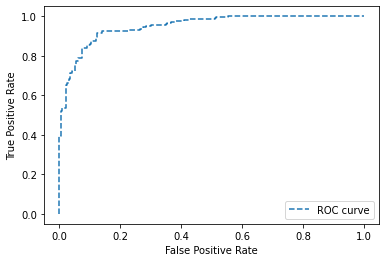

In [16]:
plot_ROC(Y, Y_hat)